In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import math
import statistics as stat
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_undergraduate_work_path = '/content/drive/My Drive/учеба/дипломная работа/colab_dir/aws/'

## Visualization Code

In [ ]:
def read_scores(model_name, start_step=0, end_step=int(1e10)):
  path = drive_undergraduate_work_path + model_name
  df = pd.read_csv(path, sep='\t', header=0)
  test_df = df[df.category.eq('TEST')]
  train_df = df[df.category.eq('TRAIN')]

  test_df = test_df[start_step <= df.step]
  test_df = test_df[df.step <= end_step]

  train_df = train_df[start_step <= df.step]
  train_df = train_df[df.step <= end_step]

  if end_step - start_step > 20000:
    train_count = train_df.shape[0]
    train_df = train_df.sample(train_count // 3)\
                        .sort_values(by=['step'])

  return test_df, train_df

def read_test_win_scores(model_name, start_step=0, end_step=int(1e10)):
  path = drive_undergraduate_work_path + model_name
  df = pd.read_csv(path, sep='\t', header=0)
  df = df[df.category.eq('TEST_WIN')]

  df = df[start_step <= df.step]
  df = df[df.step <= end_step]

  return df

In [ ]:
def metric_name_mapper(metric):
  return {
      'cross_entropy': 'Cross entropy',
      'mean_anlp': 'ANLP',
      'common_loss': 'Общая ошибка',
      'mean_auc': 'ROC-AUC'
  }[metric]

def draw_plt(train_scores, test_scores, model_names, \
             metrics=['cross_entropy', 'mean_anlp', 'common_loss', 'mean_auc']):
  fig, ax = plot.subplots(len(metrics), len(model_names))
  fig.set_figheight(28)
  fig.set_figwidth(14)

  for i, metric in enumerate(metrics):
    for j in range(len(test_scores)):
      model_name = model_names[j]
      tmp_ax = ax[i][j] if len(model_names) > 1 else ax[i]
      # tmp_ax = ax[i * len(metrics) + j]
      tmp_ax.set_xlabel('Количество итераций')
      tmp_ax.set_xlabel('Количество итераций')
      metric_name = metric_name_mapper(metric)
      tmp_ax.set_title('[%s] %s' % (model_name, metric_name))

      tmp_ax.plot(test_scores[j]['step'], test_scores[j][metric], color='red', label='Test')
      tmp_ax.plot(train_scores[j]['step'], train_scores[j][metric], color='green', label='Train')

      tmp_ax.legend()
  plot.show()

def draw_win_plt(scores, model_names):
  metrics=['mean_anlp']

  fig, ax = plot.subplots(len(metrics))
  fig.set_figheight(7)
  fig.set_figwidth(6)

  for i, metric in enumerate(metrics):
    row = i // 2
    column = i % 2
    cur_ax = ax[row][column] if len(metrics) > 1 else ax
    for j, model_name in enumerate(model_names):
      cur_ax.set_xlabel('Количество итераций')
      cur_ax.set_ylabel('Значение метрики')
      cur_ax.set_title(metric_name_mapper(metric))
      cur_ax.plot(scores[j]['step'], scores[j][metric], label=model_name)

      cur_ax.legend()
  plot.show()

def draw_single_plt(train_scores, test_scores, model_names, metrics=['cross_entropy', 'mean_anlp', 'common_loss', 'mean_auc'], train_only=False, test_only=False):
  fig, ax = plot.subplots(len(metrics) // 2, len(metrics) // 2)
  fig.set_figheight(10)
  fig.set_figwidth(9)

  for i, metric in enumerate(metrics):
    row = i // 2
    column = i % 2
    cur_ax = ax[row][column] if len(metrics) > 1 else ax
    for j, model_name in enumerate(model_names):
      cur_ax.set_xlabel('Количество итераций')
      cur_ax.set_ylabel('Значение метрики')
      cur_ax.set_title(metric_name_mapper(metric))

      if not train_only:
        label = '%s Test' % model_name if train_only == test_only else model_name
        cur_ax.plot(test_scores[j]['step'], test_scores[j][metric], label=label)
      if not test_only:
        label = '%s Train' % model_name if train_only == test_only else model_name
        cur_ax.plot(train_scores[j]['step'], train_scores[j][metric], label=label)

      cur_ax.legend()
  plot.show()

In [ ]:
_BAD_RESULT = '#FF4233'
_GOOD_RESULT = '#55E52E'
_NEUTRAL = 'w'

def _extract_row(df, metrics):
  x = {}
  for metric in metrics:
    x[metric] = df[metric].iloc[0]
  return x

def draw_mean_results_table(model_result_paths, names):
  metrics=('mean_anlp', 'mean_auc')
  results = {}

  metrics_value = {'mean_anlp': [], 'mean_auc': []}

  for i in range(len(model_result_paths)):
    df, _ = read_scores(model_result_paths[i])

    anlp_min = df['mean_anlp'].min()

    df = df[(df['mean_anlp'] == anlp_min)]
    results[names[i]] = _extract_row(df, metrics)

    for metric in metrics:
      metrics_value[metric].append(df[metric].iloc[0])

  data = [['' for _ in range(len(names) + 4)] for j in range(len(metrics))]

  for i in range(len(names)):
    model_name = names[i]
    for j in range(len(metrics)):
      metric = metrics[j]
      x = results[model_name][metric]
      sx = "{:.4f}".format(x)
      data[j][i] = sx

  for i, metric in enumerate(metrics):
    mean = np.mean(metrics_value[metric])
    std = stat.stdev(metrics_value[metric])
    var = std ** 2
    data[i][len(names)] = mean
    data[i][len(names) + 1] = std
    data[i][len(names) + 2] = 1.96 * std / math.sqrt(len(names))
    data[i][len(names) + 3] = var

  columns = names[:]
  columns.append('mean')
  columns.append('std')
  columns.append('дов. интервал')
  columns.append('var')

  table = plot.table(
      cellText=data,
      rowLabels=list(map(metric_name_mapper, metrics)),
      colLabels=columns,
      loc='center'
  )

  table.set_fontsize(16)
  table.scale(4, 4)

  plot.axis('off')
  plot.grid(False)

  plot.show()

def draw_table(model_result_paths, names, start_step=0, end_step=int(1e10)):
  metrics=('cross_entropy', 'mean_anlp', 'common_loss', 'mean_auc')

  row_names = []
  results = {}
  for i in range(len(model_result_paths)):
    test_df, _ = read_scores(model_result_paths[i], start_step, end_step)

    anlp_min = test_df['mean_anlp'].min()
    test_df = test_df[(test_df['mean_anlp'] == anlp_min)]

    row_names.append(names[i])
    results[names[i]] = _extract_row(test_df, metrics)

  data = [['' for _ in range(len(names))] for j in range(len(metrics))]
  colors = [['' for _ in range(len(names))] for j in range(len(metrics))]

  for i in range(len(names)):
    model_name = names[i]
    for j in range(len(metrics)):
      metric = metrics[j]
      x = results[model_name][metric]
      sx = "{:.4f}".format(x)
      if model_name != 'baseline' and 'baseline' in results:
        bx = results['baseline'][metric]
        diff = x - bx
        sign = '+' if x > bx else '-'
        p_diff = diff / x * 100

        if metric == 'mean_auc':
          colors[j][i] = _GOOD_RESULT if sign == '+' else _BAD_RESULT
        else:
          colors[j][i] = _GOOD_RESULT if sign == '-' else _BAD_RESULT
        data[j][i] = '%s (%s%%)' % (sx, "{:.2f}".format(p_diff))
      else:
        colors[j][i] = 'w'
        data[j][i] = sx

  table = plot.table(
      cellText=data,
      rowLabels=list(map(metric_name_mapper, metrics)),
      colLabels=names,
      loc='center',
      cellColours=colors
  )

  table.set_fontsize(16)
  table.scale(2.5, 2.5)

  plot.axis('off')
  plot.grid(False)

  plot.show()

# VK

## Vk 1

In [ ]:
dlf = 'dlf_vk1_all__0.25_0.75_0.0001_20200522_0824.tsv'
transformer = 'tlf_vk1_all__0.25_0.75_0.0001_20200522_0825.tsv'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


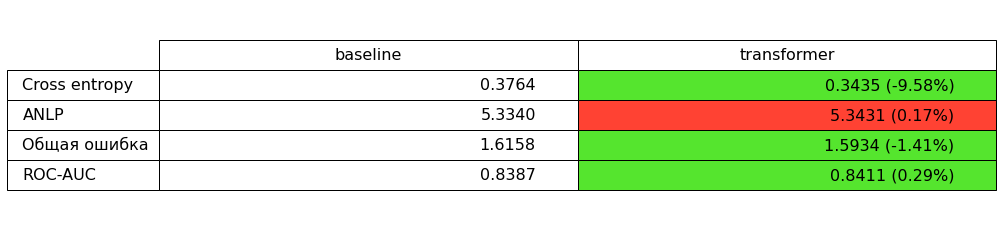

In [ ]:
draw_table(
    [dlf, transformer],
    ['baseline', 'transformer']
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


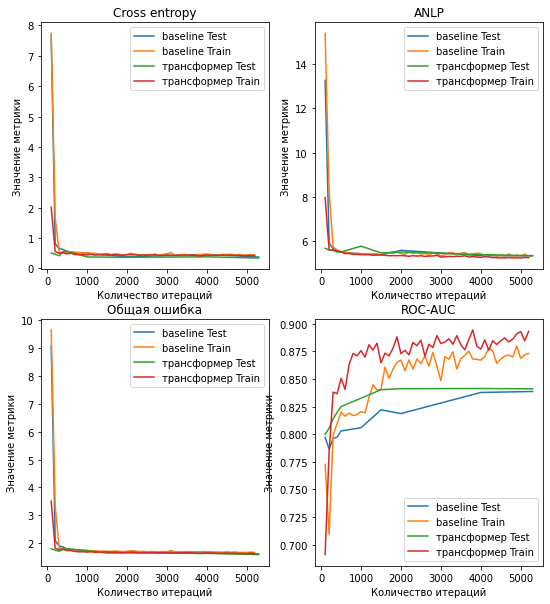

In [ ]:
dlf_test_df, dlf_train_df = read_scores(dlf, end_step=16000)
trainsformer_test_df, trainsformer_train_df = read_scores(transformer, end_step=16000)

test_scores = [dlf_test_df, trainsformer_test_df]
train_scores = [dlf_train_df, trainsformer_train_df]

draw_single_plt(train_scores, test_scores, ['baseline', 'трансформер'])
# draw_plt(train_scores, test_scores, ['baseline', 'трансформер'])

## Vk6

In [ ]:
dlf = 'dlf_vk6_all__0.25_0.75_0.0001_20200523_1829.tsv'
transformer = 'tlf_vk6_all__0.25_0.75_0.0001_20200526_0425.tsv'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


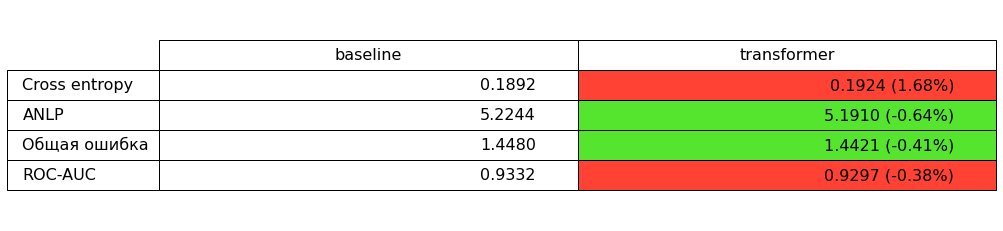

In [ ]:
draw_table(
    [dlf, transformer],
    ['baseline', 'transformer']
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


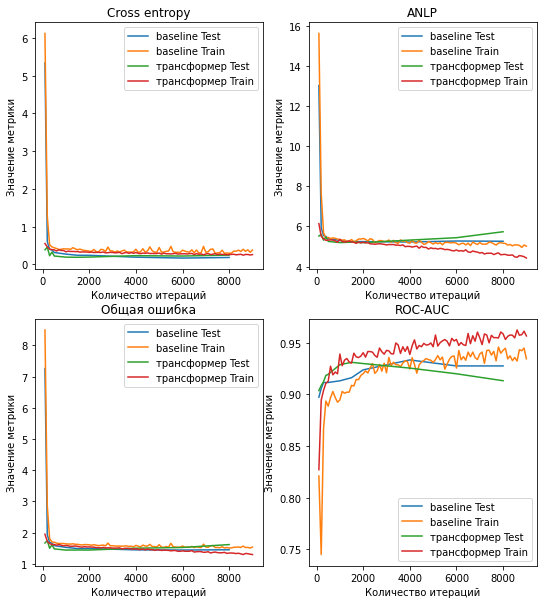

In [ ]:
dlf_test_df, dlf_train_df = read_scores(dlf, end_step=9001)
trainsformer_test_df, trainsformer_train_df = read_scores(transformer, end_step=9001)

test_scores = [dlf_test_df, trainsformer_test_df]
train_scores = [dlf_train_df, trainsformer_train_df]

draw_single_plt(train_scores, test_scores, ['baseline', 'трансформер'])
# draw_plt(train_scores, test_scores, ['baseline', 'трансформер'])

## Vk11

In [ ]:
dlf = 'dlf_vk11_all__0.25_0.75_0.0001_20200526_1526.tsv'
transformer = 'tlf_vk11_all__0.25_0.75_0.0001_20200526_1234.tsv'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


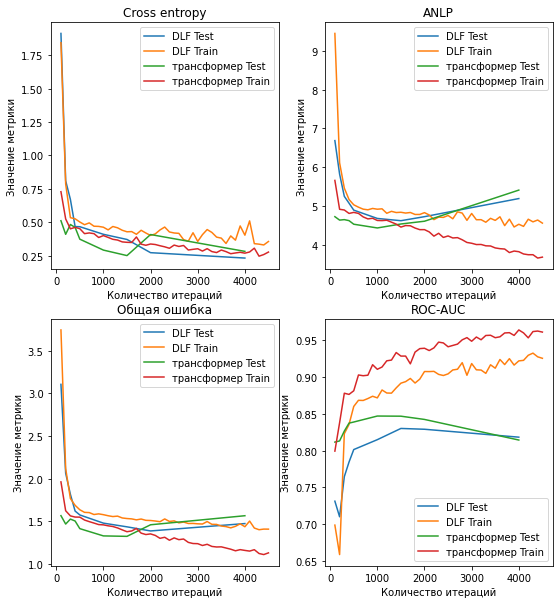

In [ ]:
dlf_test_df, dlf_train_df = read_scores(dlf, end_step=4500)
trainsformer_test_df, trainsformer_train_df = read_scores(transformer, end_step=4500)

test_scores = [dlf_test_df, trainsformer_test_df]
train_scores = [dlf_train_df, trainsformer_train_df]

draw_single_plt(train_scores, test_scores, ['DLF', 'трансформер'])
# draw_plt(train_scores, test_scores, ['baseline', 'трансформер'])

# iPinYou

### Доверительный интервал

In [ ]:
dlf01 = 'interval/dlf01_3476_all__0.25_0.75_0.0001_20200603_0532.tsv'
dlf02 = 'interval/dlf02_3476_all__0.25_0.75_0.0001_20200603_0532.tsv'
dlf03 = 'interval/dlf03_3476_all__0.25_0.75_0.0001_20200603_1233.tsv'
dlf04 = 'interval/dlf04_3476_all__0.25_0.75_0.0001_20200605_0006.tsv'
dlf05 = 'interval/dlf05_3476_all__0.25_0.75_0.0001_20200605_0639.tsv'

model_names = ['baseline01', 'baseline02', 'baseline03', 'baseline04', 'baseline05']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


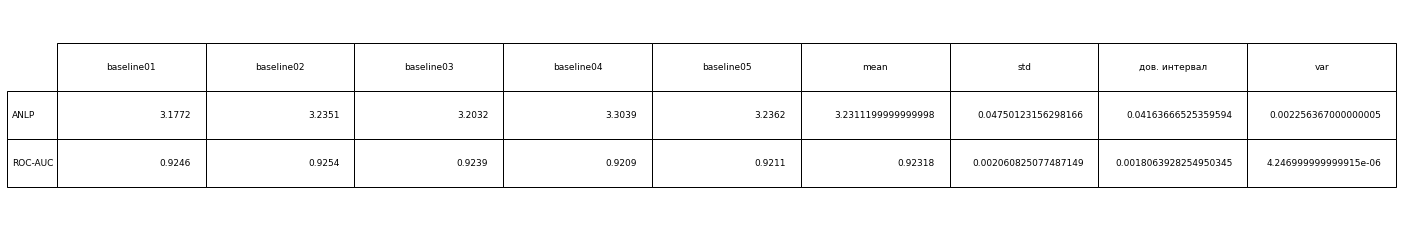

In [ ]:
draw_mean_results_table(
    [dlf01, dlf02, dlf03, dlf04, dlf05],
    model_names
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


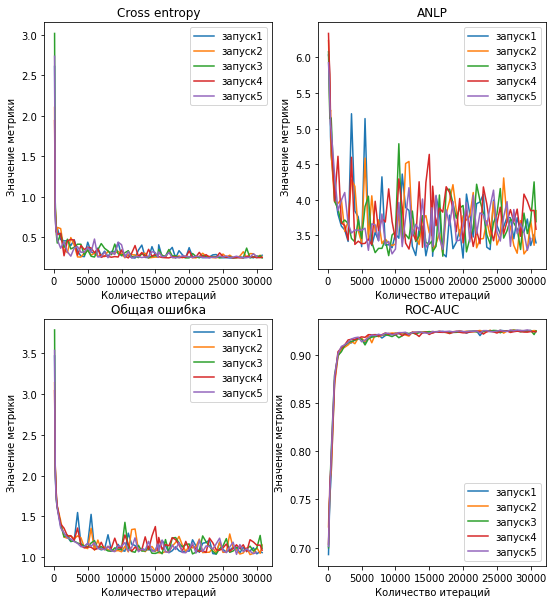

In [ ]:
test_df1, train_df1 = read_scores(dlf01)
test_df2, train_df2 = read_scores(dlf02)
test_df3, train_df3 = read_scores(dlf03)
test_df4, train_df4 = read_scores(dlf04)
test_df5, train_df5 = read_scores(dlf05)

test_scores = [test_df1, test_df2, test_df3, test_df4, test_df5]
train_scores = [train_df1, train_df2, train_df3, train_df4, train_df5]

draw_single_plt(train_scores, test_scores, ['запуск1', 'запуск2', 'запуск3', 'запуск4', 'запуск5'], test_only=True)

In [ ]:
model01 = 'interval/model1_log.tsv'
model02 = 'interval/model2_log.tsv'
model03 = 'interval/model3_log.tsv'
model04 = 'interval/model4_log.tsv'
model05 = 'interval/model5_log.tsv'

model_names = ['model01', 'model02', 'model03', 'model04', 'model05']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


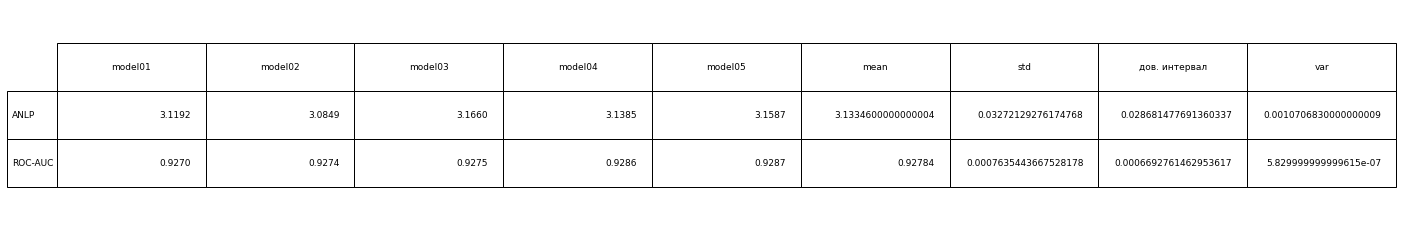

In [ ]:
draw_mean_results_table([model01, model02, model03, model04, model05], model_names)

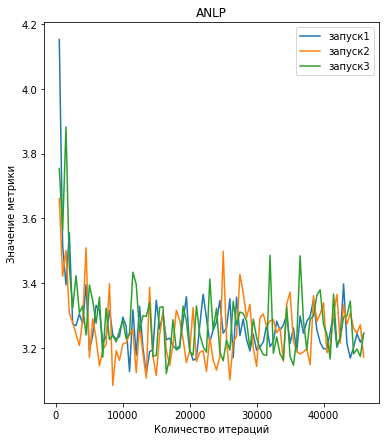

In [ ]:
# test_df1, train_df1 = read_scores(model01)
# test_df2, train_df2 = read_scores(model02)
# test_df3, train_df3 = read_scores(model03)

# test_scores = [test_df1, test_df2, test_df3]
# train_scores = [train_df1, train_df2, train_df3]

# draw_single_plt(train_scores, test_scores, model_names)

df1 = read_test_win_scores(model01)
df2 = read_test_win_scores(model02)
df3 = read_test_win_scores(model03)
df4 = read_test_win_scores(model04)
df5 = read_test_win_scores(model05)

scores = [df1, df2, df3]
draw_win_plt(scores, ['запуск1', 'запуск2', 'запуск3'])

### Холодный старт

In [ ]:
pretrained_dlf = 'cold_start/pretrained_dlf_1458_all__0.25_0.75_0.0001_20200605_0238.tsv'
simple_dlf = 'cold_start/dlf_1458_all__0.25_0.75_0.0001_20200605_1309.tsv'
fulldate_dlf = 'dlf_1458_all__0.25_0.75_0.0001_20200503_2138.tsv'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


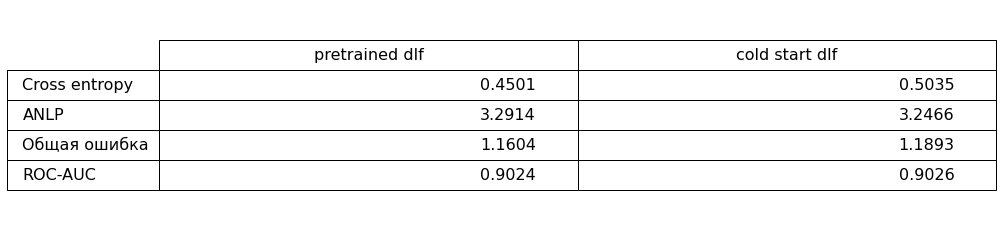

In [ ]:
draw_table([pretrained_dlf, simple_dlf], ['pretrained dlf', 'cold start dlf'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


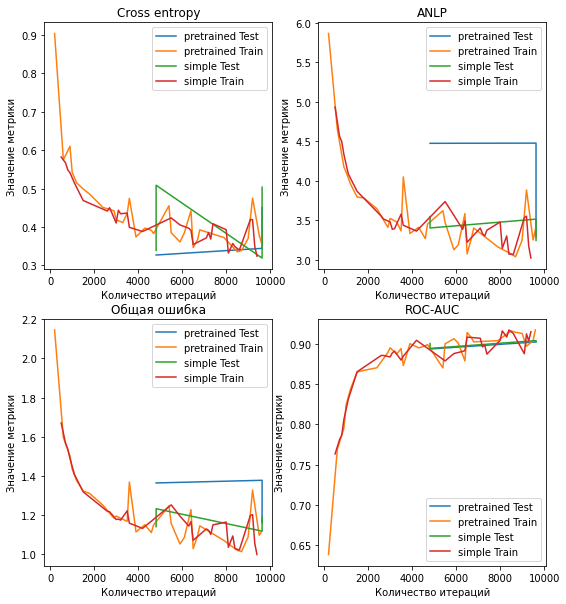

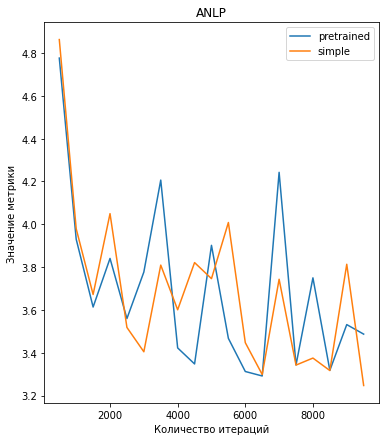

In [ ]:
model_names = ['pretrained', 'simple']

test_df1, train_df1 = read_scores(pretrained_dlf)
test_df2, train_df2 = read_scores(simple_dlf)

test_scores = [test_df1, test_df2]
train_scores = [train_df1, train_df2]

draw_single_plt(train_scores, test_scores, model_names)

df1 = read_test_win_scores(pretrained_dlf)
df2 = read_test_win_scores(simple_dlf)

scores = [df1, df2]
draw_win_plt(scores, model_names)

## Campaign 2997

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


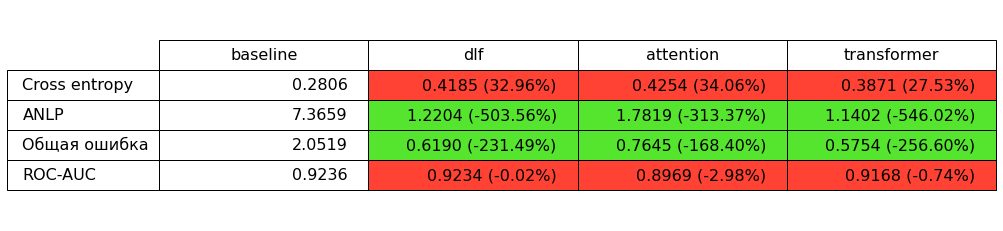

In [ ]:
baseline = 'dlf32_128_128_0.000100_0.000100_0.001000_2997_0.75_0.25_True_False_1_1.train.log.tsv'
dlf_model = 'dlf_2997_all__0.25_0.75_0.0001_20200502_1437.tsv'
attention_model = 'dlf_attention_2997_all__0.25_0.75_0.0001_20200509_2158.tsv'
transformer = 'tlf_2997_all__0.25_0.75_0.0001_20200518_2146.tsv'

draw_table(
    [baseline, dlf_model, attention_model, transformer],
    ['baseline', 'dlf', 'attention', 'transformer']
)

### All training steps

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


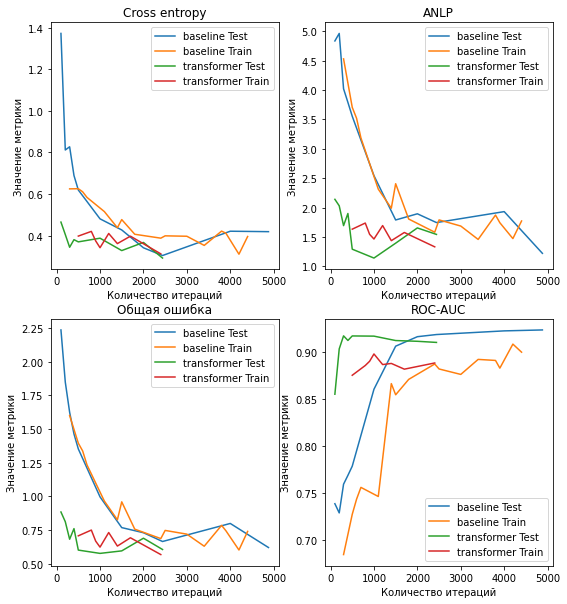

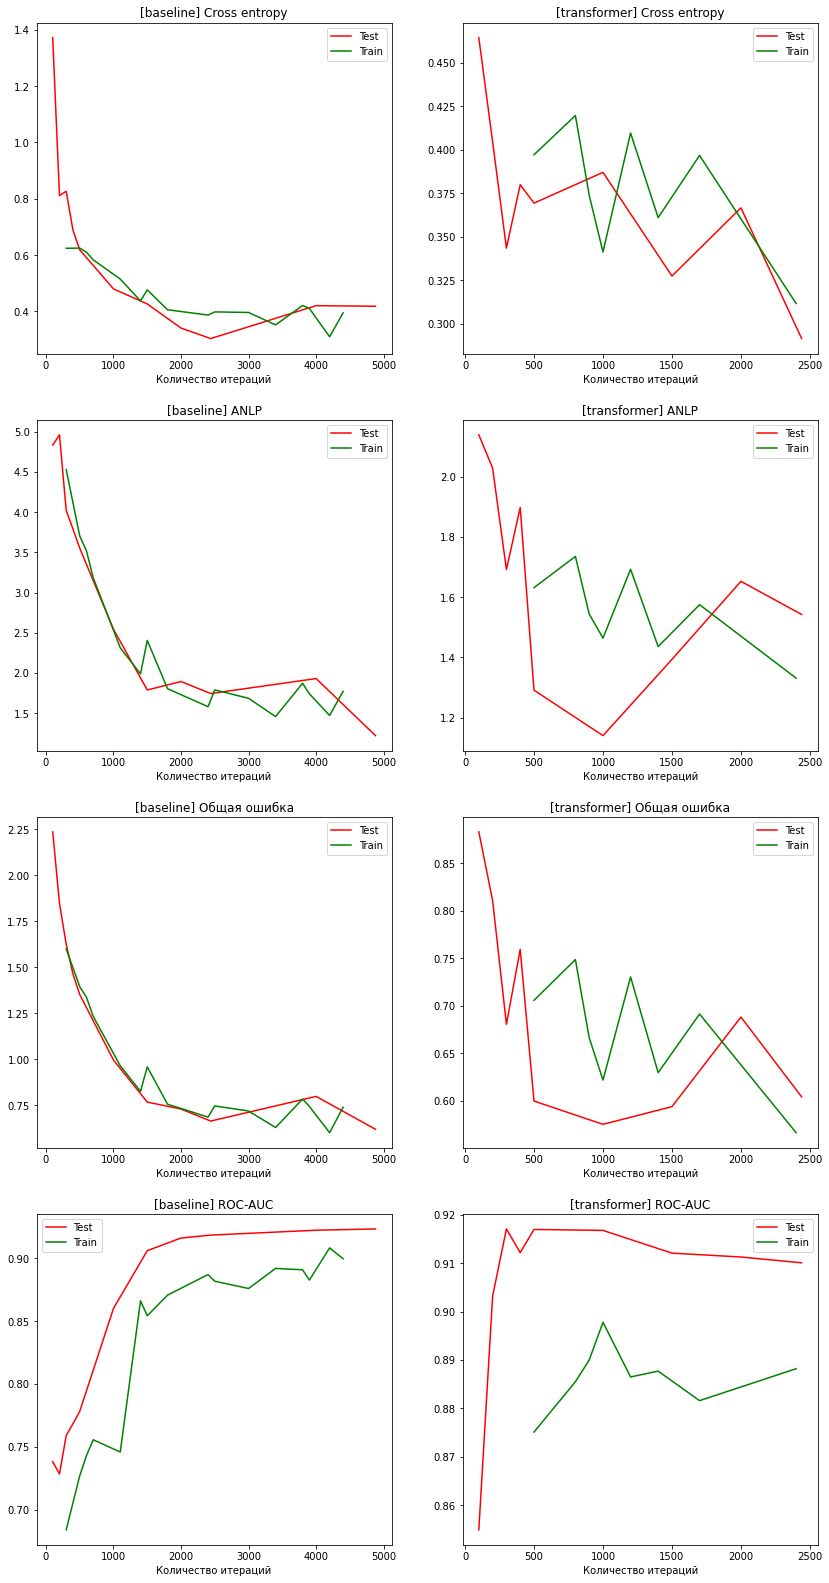

In [ ]:
baseline_test_df, baseline_train_df = read_scores(baseline, end_step=6000)
dlf_test_df, dlf_train_df = read_scores(dlf_model)
attention_test_df, attention_train_df = read_scores(attention_model, end_step=10000)
transformer_test_df, transformer_train_df = read_scores(transformer)

test_scores = [dlf_test_df, transformer_test_df]
train_scores = [dlf_train_df, transformer_train_df]

draw_single_plt(train_scores, test_scores, ['baseline', 'transformer'])
draw_plt(train_scores, test_scores, ['baseline', 'transformer'])

## Campaign 3476

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


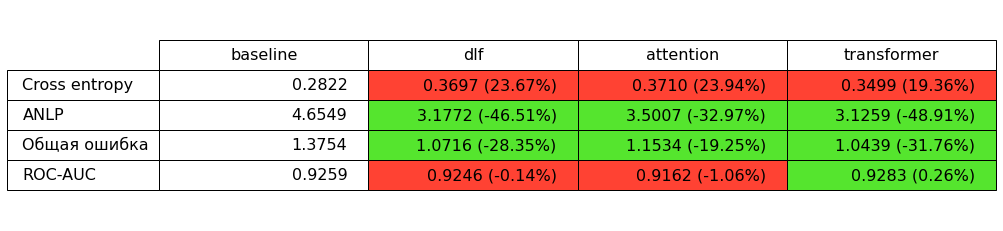

In [ ]:
dlf_model = 'dlf32_128_128_0.000100_0.000100_0.001000_3476_0.75_0.25_True_False_1_1.train.log.tsv'
my_model = 'interval/dlf01_3476_all__0.25_0.75_0.0001_20200603_0532.tsv'
attention_model = 'dlf_attention_3476_all__0.25_0.75_0.0001_20200512_1719.tsv'
transformer = 'tlf_3476_all__0.25_0.75_0.0001_20200518_1059.tsv'

draw_table([dlf_model, my_model, attention_model, transformer], ['baseline', 'dlf', 'attention', 'transformer'])

### All training steps

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


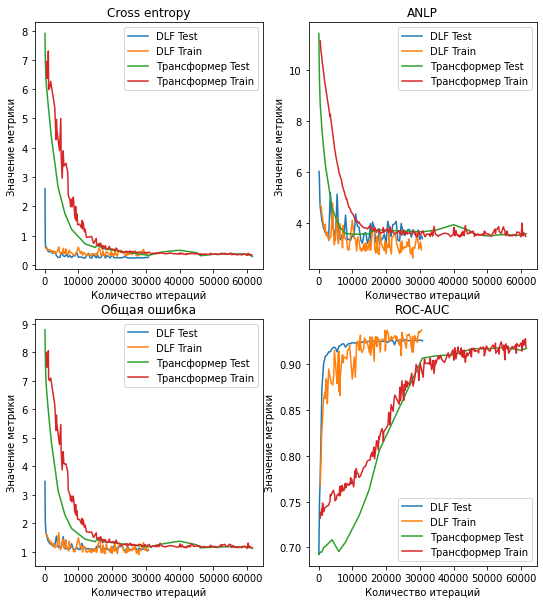

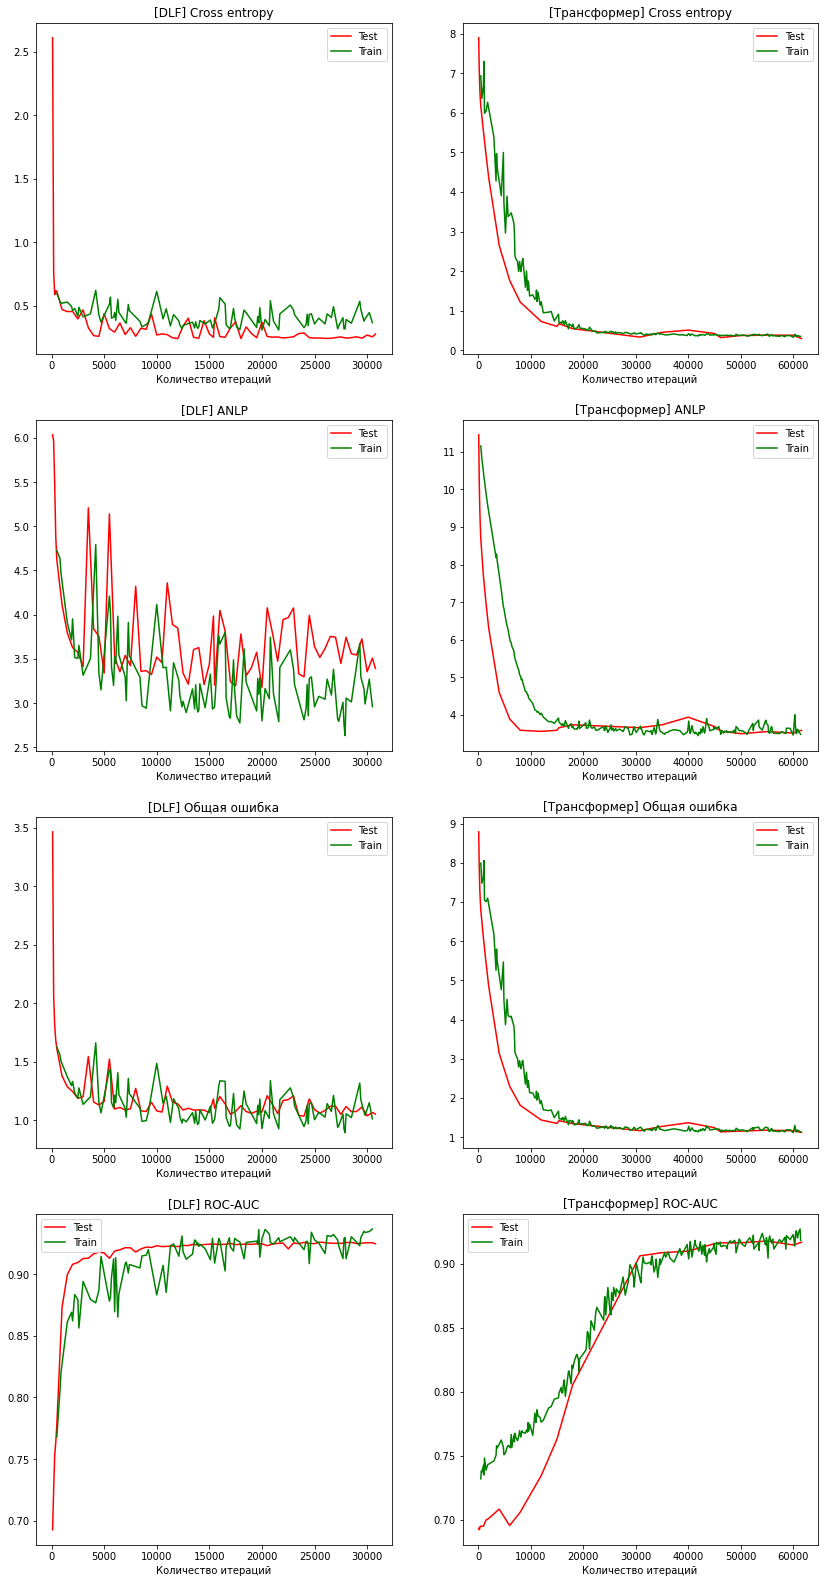

In [ ]:
my_model_test_df, my_model_train_df = read_scores(my_model)
other_model_test_df, other_model_train_df = read_scores(dlf_model)
attention_model_test_df, attention_model_train_df = read_scores(attention_model)
trainsformer_test_df, trainsformer_train_df = read_scores(transformer, end_step=16000)

test_scores = [my_model_test_df, trainsformer_test_df]
train_scores = [my_model_train_df, trainsformer_train_df]

test_scores = [my_model_test_df, attention_model_test_df]
train_scores = [my_model_train_df, attention_model_train_df]

draw_single_plt(train_scores, test_scores, ['DLF', 'Трансформер'])
draw_plt(train_scores, test_scores, ['DLF', 'Трансформер'])

# # draw_single_plt(train_scores, test_scores, ['DLF', 'Механизм внимания'], ['cross_entropy', 'mean_anlp', 'common_loss', 'mean_auc'])
# draw_single_plt(train_scores, test_scores, ['DLF', 'Механизм внимания'], ['cross_entropy', 'mean_anlp', 'mean_auc'])
# draw_plt(train_scores, test_scores, ['DLF', 'Трансформер'])

## Campaign 2259

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


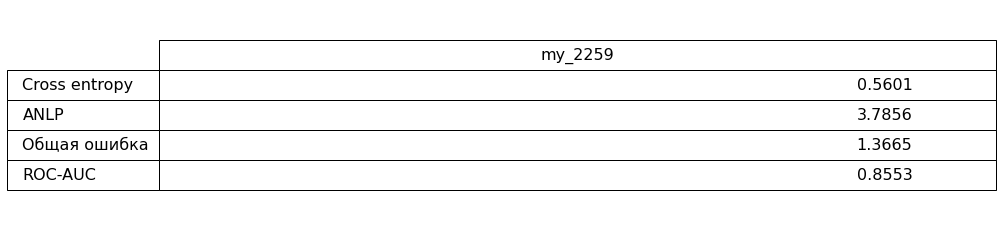

In [ ]:
my_model = 'dlf_2259_all__0.75_0.25_0.0001_20200424_1618.tsv'

draw_table([my_model], ['my_2259'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


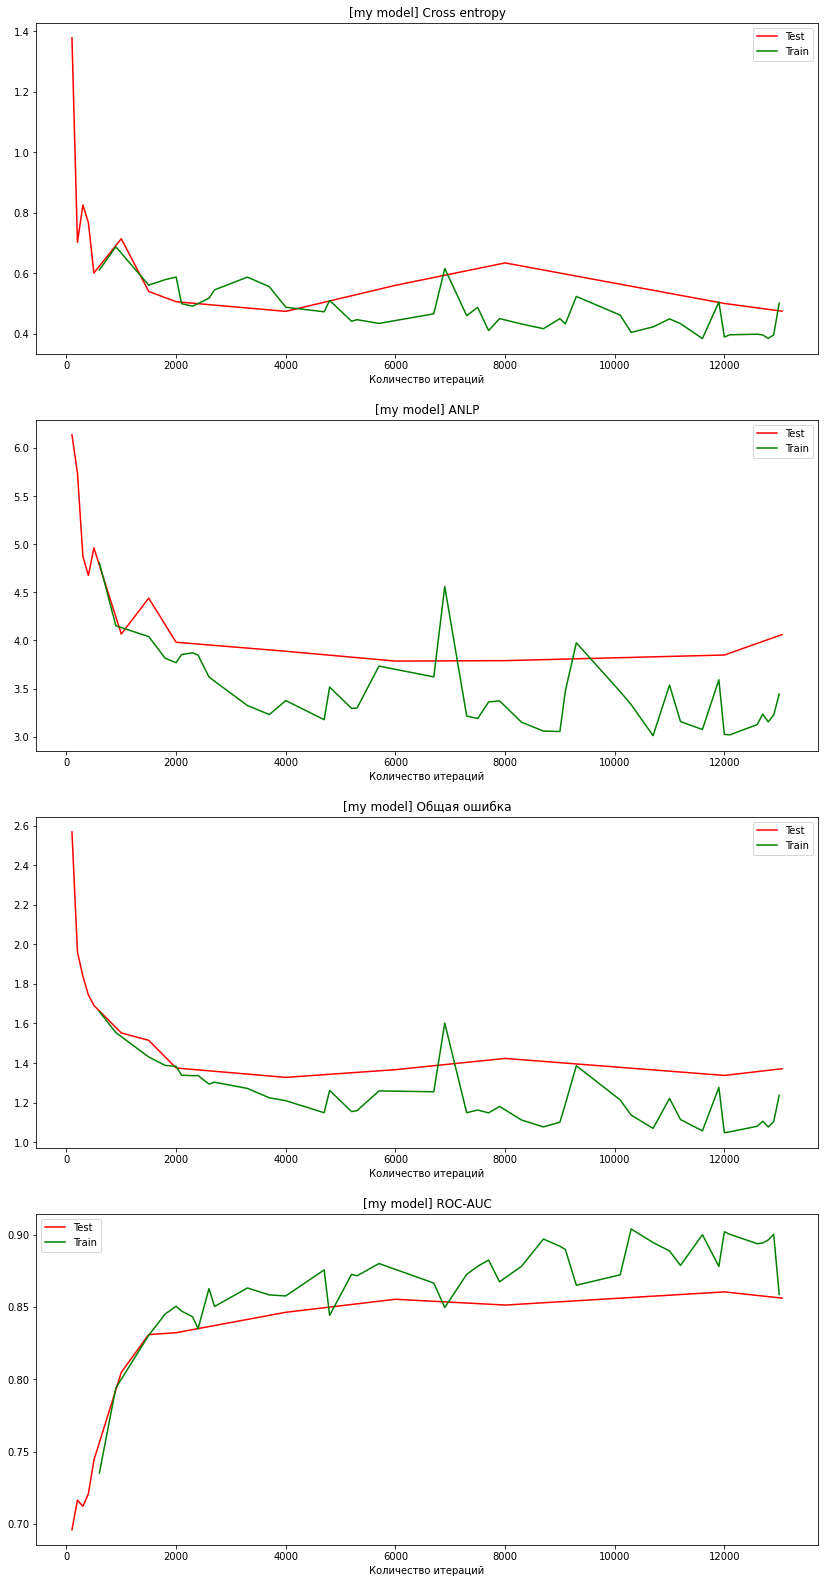

In [ ]:
my_model_test_df, my_model_train_df = read_scores(my_model)

test_scores = [my_model_test_df]
train_scores = [my_model_train_df]

draw_plt(train_scores, test_scores, ['my model'])

## Campaign 2821

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


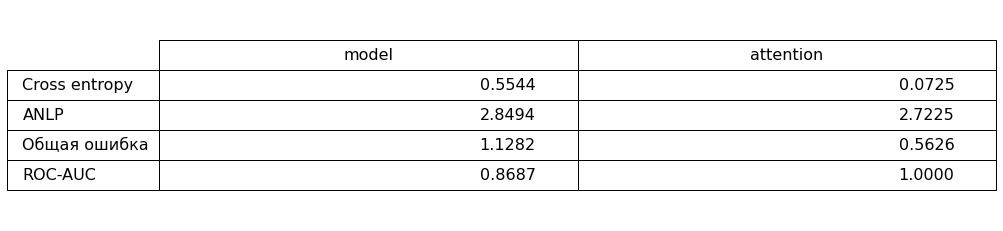

In [ ]:
my_model = 'dlf_2821_all__0.75_0.25_0.0001_20200425_0930.tsv'
attention_model = 'dlf_2821_all__0.25_0.2_0.0001_20200428_2136.tsv'
draw_table([my_model, attention_model], ['model', 'attention'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


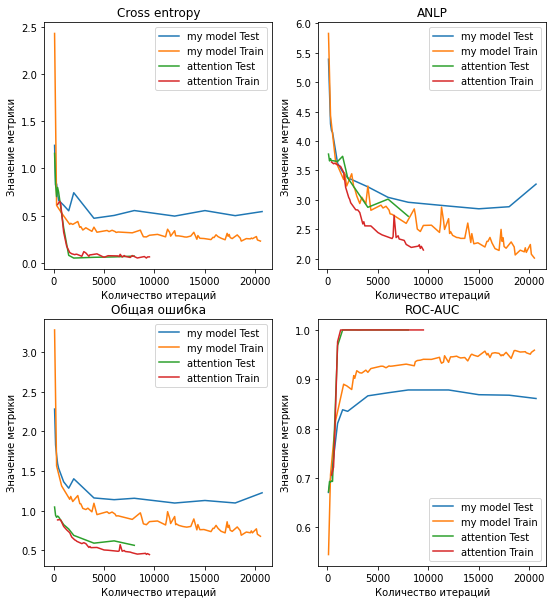

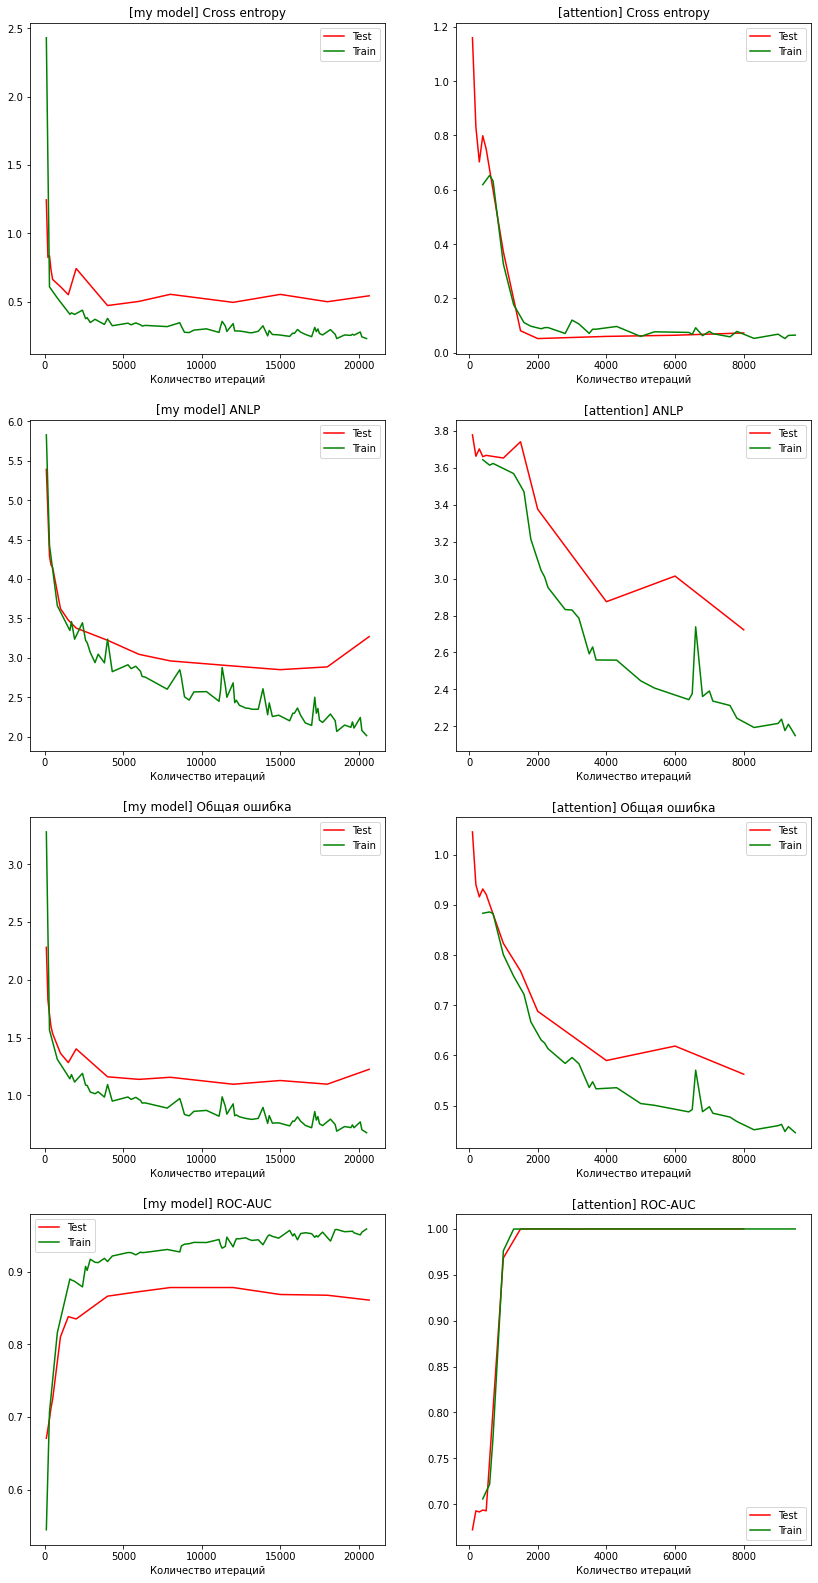

In [ ]:
my_model_test_df, my_model_train_df = read_scores(my_model)
attention_model_test_df, attention_model_train_df = read_scores(attention_model)

test_scores = [my_model_test_df, attention_model_test_df]
train_scores = [my_model_train_df, attention_model_train_df]

draw_single_plt(train_scores, test_scores, ['my model', 'attention'])
draw_plt(train_scores, test_scores, ['my model', 'attention'])